# Read Prod6 simtel file and test reduced readout window effect

Use env variables for PROD_DIR and OUT_DIR, if they exist.

If not interactive, use command line arguments, with defaults.

In [1]:
from ctapipe.io import EventSource,DataWriter
from ctapipe import utils
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

/home/punch/miniconda3/envs/ctapipe_0.24/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from ctapipe.visualization import CameraDisplay
from ctapipe.coordinates import EngineeringCameraFrame
from ctapipe.calib import CameraCalibrator
from ctapipe.instrument import SoftwareTrigger
from ctapipe.image import tailcuts_clean

In [3]:
from ctapipe.image import (
     ImageProcessor,
     camera_to_shower_coordinates,
     concentration_parameters,
     hillas_parameters,
     leakage_parameters,
     number_of_islands,
     timing_parameters,
     toymodel,
 )
from traitlets.config import Config
from ctapipe.reco import ShowerProcessor

In [4]:
from astropy import units as u

In [5]:
from astropy.coordinates import AltAz, angular_separation

In [81]:
import os
import sys

In [42]:
from glob import glob,iglob

In [38]:
import argparse

In [19]:
from ctapipe.version import version

In [20]:
version

'0.24.0'

## Get Env variables

In [49]:
if hasattr(sys,'ps1'):
    site = "LaPalma"
    particle = "gamma"
else:
    parser = argparse.ArgumentParser(
                    prog='Make_reduced_Readout_window',
                    description='Makes DL2(?) files with a reduced readout window (or not)',
                    #epilog='',
                    )
    parser.add_argument("--site","-s",help="Choose site: LaPalma or Paranal (default LaPalma)",
                       nargs='?', default='LaPalma')
    parser.add_argument("--particle","-p",help="Choose particle: gamma, gamma-diffuse, proton, electron",
                       nargs='?', default='gamma')
    parser.add_argument("--reduced-window","-r",action=argparse.BooleanOptionalAction,
                        default=True,help="Hardwired reduced window, or standard as simulated")
    args = parser.parse_args()
    #print("args:",args)
    
    site = args.site
    particle = args.particle
    ReduceWindow = True if args.reduced_window else False
    if particle not in ["gamma", "gamma-diffuse", "proton", "electron"]:
        print(f"Error:\n" 
              f"  Particle type \"{particle}\" unknown. \n"
               "  Must choose particle type in : gamma, gamma-diffuse, proton, electron")
        sys.exit()

In [51]:
# If environment variable exists, use it
try:
    PROD_DIR = '{PROD_DIR}'.format(**os.environ)
except KeyError:
    PROD_DIR = f"/media/punch/CTA_Data/Prod6/LaPalma/2025/{particle}"

try:
    OUT_DIR = '{OUT_DIR}'.format(**os.environ)
except KeyError:
    OUT_DIR = "/scr/punch/CTA/Prod6/LaPalma/2025/"

PROD_DIR,OUT_DIR

('/media/punch/CTA_Data/Prod6/LaPalma/2025/gamma',
 '/scr/punch/CTA/Prod6/LaPalma/2025/')

## Forget about CTAO-S

In [26]:
#gamma_file = "/scr/punch/CTA/Prod6/Paranal/gamma_20deg_0deg_run000001___cta-prod6-2147m-Paranal-dark.simtel.zst"
#proton_file = "/scr/punch/CTA/Prod6/Paranal/proton_20deg_0deg_run000001___cta-prod6-2147m-Paranal-dark.simtel.zst"

## CTAO-N files

In [61]:
if particle != "gamma_diffuse":
    simtel_files = glob(PROD_DIR+f"/{particle}*.simtel.zst")
    if particle == "gamma": # Sift out any diffuse files there might be in there
        simtel_files = [sf for sf in simtel_files if not "cone" in sf]
else:
    simtel_files = glob(PROD_DIR+f"/gamma*cone*.simtel.zst")

In [63]:
if len(simtel_files):
    print(f"{len(simtel_files)} files found.")
else:
    if os.path.isdir(PROD_DIR):
        print(f"Error: No {particle} files found in {PROD_DIR}.")
    else:
        print(f"Error: Prod directory {PROD_DIR} does not exist.")
    sys.exit()

50 files found.


In [83]:
if not os.path.isdir(OUT_DIR):
    print(f"Error: Output directory {OUT_DIR} does not exist.")
else:
    print(f"Writing outputs in {OUT_DIR}.")

Writing outputs in /scr/punch/CTA/Prod6/LaPalma/2025/.


In [64]:
first_file = simtel_files[0]

In [65]:
#simtel_files = simtel_files[17:]

In [66]:
if "palma" in site.lower():
    # This looks something like the layout in 
    # https://indico.cta-observatory.org/event/3962/contributions/32718/attachments/21055/29677/20220310_NorthernArray.pdf
    tels_alpha = [1,2,3,4,5,6,7,8,9,10,11,14,19]
else:
    # 
    # https://indico.cta-observatory.org/event/4368/contributions/36020/attachments/22589/32376/AD-6%20INFRA%20DES%20100-058-S.pdf
    tels_alpha = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,
                  38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,
                  58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77]  # Maybe should stop at (including) 74?? https://github.com/Eventdisplay/Eventdisplay_AnalysisFiles_CTA/blob/a534e533199b0305b86d4006956f032388636b56/DetectorGeometry/CTA.prod6S.Am-0LSTs14MSTs37SSTs.lis#L4
    

In [67]:
source = EventSource(first_file,allowed_tels=tels_alpha)
#source = EventSource(proton_file)

In [68]:
source.allowed_tels

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19}

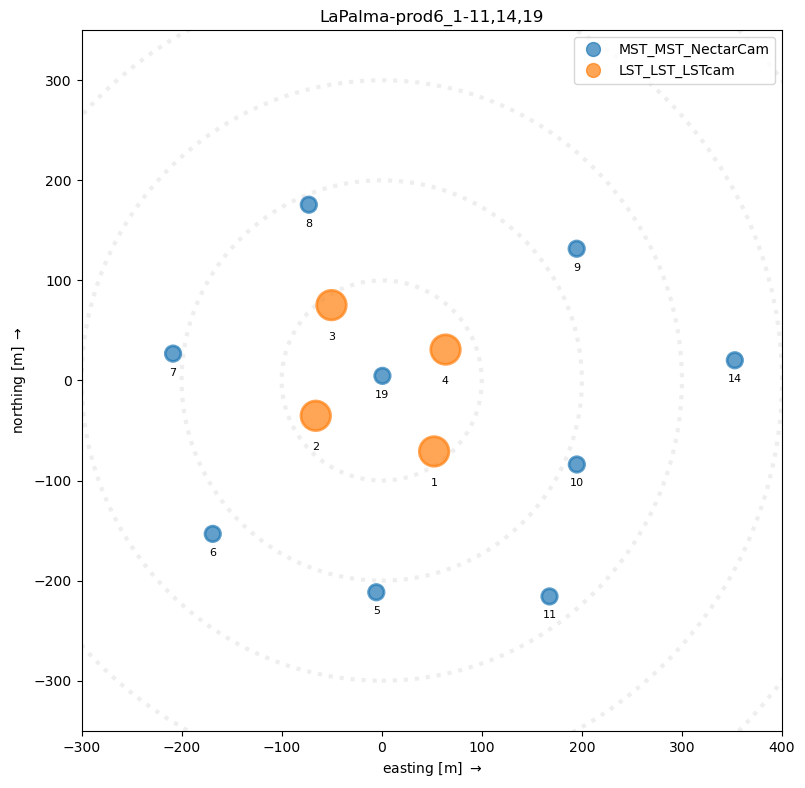

In [69]:
#sub_alpha = source.subarray.select_subarray(tel_ids=tels_alpha)
#sub_alpha = source.subarray.select_subarray(tel_ids=[2,3,4])
#ArrayDisplay(sub_alpha)
#sub_alpha.peek()
source.subarray.peek()
plt.xlim([-300,400])
plt.ylim([-350,350])
#
plt.show()

## From https://ctapipe.readthedocs.io/en/v0.20.0/auto_examples/tutorials/ctapipe_overview.html

But, thresholds taken from ctapipe-process base_config.yaml

And subarray as sub_alpha

In [70]:
source = EventSource(first_file,allowed_tels=tels_alpha)
#source = EventSource(proton_file)

In [71]:
source = EventSource(first_file,allowed_tels=tels_alpha)
event_iter = iter(source)

In [72]:
source.subarray

SubarrayDescription(name='LaPalma-prod6_1-11,14,19', n_tels=13)

In [73]:
tels_alpha

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19]

In [74]:
#sub_alpha = source.subarray.select_subarray(tels_alpha)

In [75]:
#sub_alpha

In [76]:
event = next(event_iter)

In [77]:
event.trigger.tels_with_trigger

array([10])

In [78]:
calibrator = CameraCalibrator(subarray=source.subarray)

In [79]:
calibrator(event)

In [ ]:
source.close()

## Main Loop
### Adapting from https://ctapipe.readthedocs.io/en/latest/auto_examples/tutorials/ctapipe_overview.html

But then using the configs for running on the grid: https://gitlab.cta-observatory.org/cta-computing/dpps/datapipe/pipeline-configurations
... which I've saved here, so can read in.

In [23]:
import yaml

In [25]:
from pprint import pprint

In [26]:
with open("dl0_to_dl1.yml") as stream:
    try:
        dl0_to_dl1 = yaml.safe_load(stream)
        pprint(dl0_to_dl1)
    except yaml.YAMLError as exc:
        print(exc)

{'CameraCalibrator': {'image_extractor_type': [['type',
                                                '*',
                                                'NeighborPeakWindowSum'],
                                               ['type',
                                                '*FlashCam',
                                                'FlashCamExtractor']]},
 'DataWriter': {'Contact': {'email': 'maximilian.linhoff@tu-dortmund.de',
                            'name': 'Maximilian Linhoff',
                            'organization': 'CTAO / DPPS'},
                'transform_image': True,
                'transform_peak_time': True,
                'write_dl1_images': True,
                'write_dl1_parameters': False,
                'write_dl2': False}}


In [27]:
with open("dl1_to_dl2.yml") as stream:
    try:
        dl1_to_dl2 = yaml.safe_load(stream)
        pprint(dl1_to_dl2)
    except yaml.YAMLError as exc:
        print(exc)

{'DataWriter': {'Contact': {'email': 'maximilian.linhoff@tu-dortmund.de',
                            'name': 'Maximilian Linhoff',
                            'organization': 'CTAO / DPPS'},
                'write_dl1_images': False,
                'write_dl1_parameters': True,
                'write_dl2': True},
 'ImageProcessor': {'ImageQualityQuery': {'quality_criteria': [['enough_pixels',
                                                                'np.count_nonzero(image) '
                                                                '> 2'],
                                                               ['enough_charge',
                                                                'image.sum() > '
                                                                '50']]},
                    'TailcutsImageCleaner': {'boundary_threshold_pe': [['type',
                                                                        'LST*',
                                            

In [28]:
from copy import deepcopy

In [29]:
def ReadoutWindowReducer(event,subarray):
    """
    Fixed Readout Window Reducer
    (Fixed over all camera)
    Reduce the readout window for MSTs and LSTs.
    Hardcoded for now, with for MSTs [12:28] and LSTs [10:30]
    """

    for tel_id in event.trigger.tels_with_trigger:
        # Maybe this would be faster? tel in subarray.get_tel_ids_for_type("MST_MST_NectarCam"):
        cam_name_lower = source.subarray.tel[tel_id].camera_name.lower()
        if "nectarcam" == cam_name_lower:
            event.r0.tel[tel_id].waveform = event.r0.tel[tel_id].waveform[:, :, 12:28]
            event.r1.tel[tel_id].waveform = event.r1.tel[tel_id].waveform[:, :, 12:28]
        elif "lstcam" == cam_name_lower: 
            event.r0.tel[tel_id].waveform = event.r0.tel[tel_id].waveform[:, :, 10:30]
            event.r1.tel[tel_id].waveform = event.r1.tel[tel_id].waveform[:, :, 10:30]
        else:
            print(f"For {tel_id}, unknown camera type {source.subarray.tel[tel_id].camera_name}!!!")

In [54]:
from pathlib import Path

In [55]:
for in_file in simtel_files:
    
    #for ReduceWindow in [False,True]:

        in_path = Path(in_file)
        print(in_path.stem,ReduceWindow)

        out_file = in_path.stem[:-7]
        
        #ReduceWindow = True # False # 
        
        out_file = OUT_DIR+out_file
        if ReduceWindow:
           out_file += ".redwindow.h5"
        else:
           out_file += ".stdwindow.h5"
        
        source = EventSource(in_file,allowed_tels=tels_alpha)
        
        image_processor_config = Config(dl1_to_dl2["ImageProcessor"])
        shower_processor_config = Config(dl1_to_dl2["ShowerProcessor"])
        software_trigger_config = Config(dl1_to_dl2["SoftwareTrigger"])
                                     
        software_trigger = SoftwareTrigger(subarray=source.subarray, config=software_trigger_config)
        
        calibrator = CameraCalibrator(subarray=source.subarray)
        
        image_processor = ImageProcessor(
             subarray=source.subarray, config=image_processor_config
        )
        
        shower_processor = ShowerProcessor(subarray=source.subarray)
        horizon_frame = AltAz()
        
        with DataWriter(source, output_path=out_file, overwrite=True, write_dl1_parameters=True, write_dl2=True) as writer:
        
             for event in source:
                 event_count = event.count
                 if not event_count%1000:
                     print(event_count, end=" ")
                 if software_trigger(event):
                     if ReduceWindow:
                         ReadoutWindowReducer(event,subarray=source.subarray)
                     calibrator(event)
                     image_processor(event)
                     shower_processor(event)
        
                     writer(event)
        
                     if len(event.trigger.tels_with_trigger) > 9:
                         plotting_event = deepcopy(event)

             # Added to get the 
             writer.write_simulated_shower_distributions(source.simulated_shower_distributions)
             print()

gamma_20deg_0deg_run000068___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 8577314, tel_id = 8, tels_with_trigger: [3]



gamma_20deg_0deg_run000068___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 8577314, tel_id = 8, tels_with_trigger: [3]



gamma_20deg_0deg_run000053___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 4006303, tel_id = 7, tels_with_trigger: [3]


1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000053___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 4006303, tel_id = 7, tels_with_trigger: [3]


1000 
gamma_20deg_0deg_run000058___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 3061013, tel_id = 9, tels_with_trigger: [3]


1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000058___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 3061013, tel_id = 9, tels_with_trigger: [3]


1000 
gamma_20deg_0deg_run000030___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000030___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000012___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000012___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000060___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000060___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000059___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000059___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000015___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 2122109, tel_id = 8, tels_with_trigger: [3]


1000 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 9569305, tel_id = 8, tels_with_trigger: [3]
TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000015___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 2122109, tel_id = 8, tels_with_trigger: [3]


1000 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 9569305, tel_id = 8, tels_with_trigger: [3]



gamma_20deg_0deg_run000067___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 
gamma_20deg_0deg_run000067___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 
gamma_20deg_0deg_run000016___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 5852508, tel_id = 5, tels_with_trigger: [1]


1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000016___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 5852508, tel_id = 5, tels_with_trigger: [1]


1000 
gamma_20deg_0deg_run000082___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000082___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000051___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000051___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000063___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000063___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000018___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 
gamma_20deg_0deg_run000018___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 
gamma_20deg_0deg_run000069___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000069___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000029___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 2743616, tel_id = 14, tels_with_trigger: [3]


1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000029___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 2743616, tel_id = 14, tels_with_trigger: [3]


1000 
gamma_20deg_0deg_run000084___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000084___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000081___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000081___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000057___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000057___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000070___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 5911519, tel_id = 8, tels_with_trigger: [3]


1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000070___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 5911519, tel_id = 8, tels_with_trigger: [3]


1000 
gamma_20deg_0deg_run000056___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 
gamma_20deg_0deg_run000056___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 
gamma_20deg_0deg_run000088___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000088___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000083___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000083___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000054___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000054___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000085___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000085___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000023___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000023___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000001___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000001___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000087___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000087___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000062___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000062___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000035___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000035___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000010___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 112816, tel_id = 6, tels_with_trigger: [2]


1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000010___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 112816, tel_id = 6, tels_with_trigger: [2]


1000 
gamma_20deg_0deg_run000009___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000009___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000086___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000086___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000061___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 2441703, tel_id = 19, tels_with_trigger: [1]
Encountered telescope event not present in stereo trigger information, skipping. event_id = 3743017, tel_id = 8, tels_with_trigger: [3]


1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000061___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 2441703, tel_id = 19, tels_with_trigger: [1]
Encountered telescope event not present in stereo trigger information, skipping. event_id = 3743017, tel_id = 8, tels_with_trigger: [3]


1000 
gamma_20deg_0deg_run000055___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 
gamma_20deg_0deg_run000055___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 
gamma_20deg_0deg_run000038___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000038___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000028___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000028___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000065___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 4740419, tel_id = 19, tels_with_trigger: [4]


1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000065___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 

Encountered telescope event not present in stereo trigger information, skipping. event_id = 4740419, tel_id = 19, tels_with_trigger: [4]


1000 
gamma_20deg_0deg_run000066___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000066___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 
gamma_20deg_0deg_run000064___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel False


TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types


0 1000 

TelescopeParameter type argument 'SST*' did not match any known telescope types
TelescopeParameter type argument 'SST*' did not match any known telescope types



gamma_20deg_0deg_run000064___cta-prod6-2156m-LaPalma-dark+magic_cone10.simtel True
0 1000 


In [56]:
from ctapipe.io import DataWriter, EventSource, TableLoader

In [57]:
loader = TableLoader(out_file)
events = loader.read_subarray_events()

In [58]:
events.colnames

['obs_id',
 'event_id',
 'time',
 'tels_with_trigger',
 'event_type',
 'true_energy',
 'true_alt',
 'true_az',
 'true_core_x',
 'true_core_y',
 'true_h_first_int',
 'true_x_max',
 'true_starting_grammage',
 'true_shower_primary_id',
 'HillasReconstructor_alt',
 'HillasReconstructor_alt_uncert',
 'HillasReconstructor_az',
 'HillasReconstructor_az_uncert',
 'HillasReconstructor_ang_distance_uncert',
 'HillasReconstructor_core_x',
 'HillasReconstructor_core_y',
 'HillasReconstructor_core_uncert_x',
 'HillasReconstructor_core_uncert_y',
 'HillasReconstructor_core_tilted_x',
 'HillasReconstructor_core_tilted_y',
 'HillasReconstructor_core_tilted_uncert_x',
 'HillasReconstructor_core_tilted_uncert_y',
 'HillasReconstructor_h_max',
 'HillasReconstructor_h_max_uncert',
 'HillasReconstructor_is_valid',
 'HillasReconstructor_average_intensity',
 'HillasReconstructor_goodness_of_fit',
 'HillasReconstructor_telescopes']

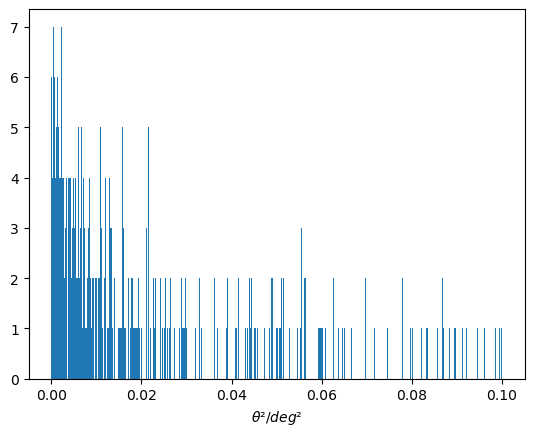

In [59]:
theta = angular_separation(
     events["HillasReconstructor_az"].quantity,
     events["HillasReconstructor_alt"].quantity,
     events["true_az"].quantity,
     events["true_alt"].quantity,
)

plt.hist(theta.to_value(u.deg) ** 2, bins=500, range=[0, 0.1])
plt.xlabel(r"$\theta² / deg²$")
None

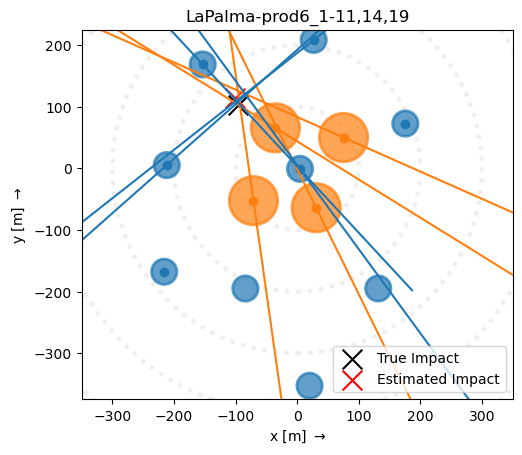

In [60]:
from ctapipe.visualization import ArrayDisplay, CameraDisplay

angle_offset = plotting_event.pointing.array_azimuth

plotting_hillas = {
    tel_id: dl1.parameters.hillas for tel_id, dl1 in plotting_event.dl1.tel.items()
}

plotting_core = {
    tel_id: dl1.parameters.core.psi for tel_id, dl1 in plotting_event.dl1.tel.items()
}


disp = ArrayDisplay(source.subarray)

disp.set_line_hillas(plotting_hillas, plotting_core, 500)

plt.scatter(
     plotting_event.simulation.shower.core_x,
     plotting_event.simulation.shower.core_y,
     s=200,
     c="k",
     marker="x",
     label="True Impact",
)
plt.scatter(
     plotting_event.dl2.stereo.geometry["HillasReconstructor"].core_x,
     plotting_event.dl2.stereo.geometry["HillasReconstructor"].core_y,
     s=200,
     c="r",
     marker="x",
     label="Estimated Impact",
)

plt.legend(loc="lower right")
plt.xlim(-350, 350)
plt.ylim(-375, 225)
None